In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as mse

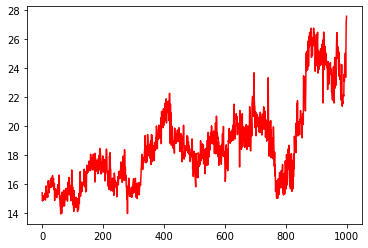

In [2]:
import pandas as pd

csv_file_path = 'close.csv'

df = pd.read_csv(csv_file_path, header=None)

close = df[0].tolist()
logclose = np.log(close).tolist()


plt.plot(close , color = 'r')
plt.show()

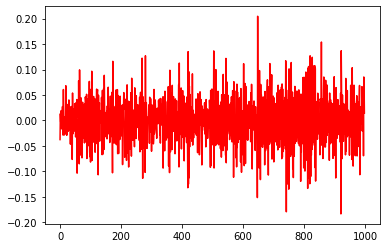

In [3]:
from math import floor

size = len(close) - 100
close_train, close_test = close[0:size], close[size:len(close)]
logclose_train, logclose_test = logclose[0:size], logclose[size:len(logclose)]

logreturns = np.diff(logclose).tolist()
logreturns_train, logreturns_test = logreturns[0:size-1], logreturns[size-1:len(logreturns)]

series = logreturns
train = logreturns_train
test = logreturns_test

plt.plot(series , color = 'r')
plt.show()

train = np.array(train).reshape(-1,1)


In [4]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import hyperopt
import warnings


space = {
    "window_size": hp.choice("window_size", range(2,20)),
    "kernel": hp.choice("kernel", ["linear", "poly", "rbf"]),
    "C": hp.loguniform("C", np.log(0.001), np.log(100)),
    "epsilon": hp.loguniform("epsilon", np.log(0.00001), np.log(1)),
    "gamma": hp.choice("gamma", ["scale", "auto"]),
    "degree": hp.quniform("degree", 2, 4, 1),  
    "coef0": hp.uniform("coef0", -5, 5)      
}

def objective(params):
    window_size = params["window_size"]
    kernel = params["kernel"]
    C = params["C"]
    epsilon = params["epsilon"]

    scaler = StandardScaler()

    train_scaled = scaler.fit_transform(train)
    train_X, train_Y = [], []
    for i in range(len(train_scaled) - window_size):
        train_X.append(train_scaled[i:i+window_size])
        train_Y.append(train_scaled[i+window_size])
    new_train_X = np.array([x.reshape(-1) for x in train_X])
    new_train_Y = np.array(train_Y).ravel()

    svr_params = {"C": C, "epsilon": epsilon}
    
    if kernel == "poly":
        svr_params["gamma"] = params["gamma"]
        svr_params["degree"] = int(params["degree"]) 
        svr_params["coef0"] = (params["coef0"])   
    elif kernel == "rbf":
        svr_params["gamma"] = params["gamma"]

    model = SVR(kernel=kernel, **svr_params)

    tscv = TimeSeriesSplit(n_splits=2)
    score = np.mean(cross_val_score(model, new_train_X, new_train_Y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1))
    
    return {"loss": -score, "status": STATUS_OK}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

best_loss = trials.best_trial['result']['loss']
best_score = best_loss

print("\n------------------------")
print("BEST OVERALL RESULTS:")
print("------------------------")
print("Best parameters (raw indices and values):")
print(best)
print(f"Best score: {best_score:.4f}")


100%|██████████| 100/100 [01:07<00:00,  1.47trial/s, best loss: 0.7952973432496733]

------------------------
BEST OVERALL RESULTS:
------------------------
Best parameters (raw indices and values):
{'C': 44.90311980741944, 'coef0': 3.4049907627936973, 'degree': 2.0, 'epsilon': 0.16919801382305844, 'gamma': 1, 'kernel': 1, 'window_size': 1}
Best score: 0.7953


In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
import numpy as np

window_sizes = range(2,20)
kernels_list = ["linear", "poly", "rbf"]
gamma_list = ["scale", "auto"]

window_size = window_sizes[best["window_size"]]
best_kernel = kernels_list[best["kernel"]]
best_gamma = gamma_list[best["gamma"]]
best_C = best["C"]
best_epsilon = best["epsilon"]
best_degree = int(best["degree"]) if best_kernel == "poly" else None
best_coef0 = (best["coef0"]) if best_kernel == "poly" else None

scaler = StandardScaler()

train_scaled = scaler.fit_transform(train)
train_X, train_Y = [], []
for i in range(0, len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])

new_train_X = np.array([x.reshape(-1) for x in train_X])
new_train_Y = np.array(train_Y).ravel()

svr_params = {"C": best_C, "epsilon": best_epsilon}
if best_kernel == "poly":
    svr_params["gamma"] = best_gamma
    svr_params["degree"] = best_degree
    svr_params["coef0"] = best_coef0
elif best_kernel == "rbf":
    svr_params["gamma"] = best_gamma

model = SVR(kernel=best_kernel, **svr_params)

model.fit(new_train_X, new_train_Y)


SVR(C=44.90311980741944, coef0=3.4049907627936973, degree=2,
    epsilon=0.16919801382305844, gamma='auto', kernel='poly')

In [6]:
print(window_size)
print(best_kernel)
print(best_gamma)
print(best_C)
print(best_epsilon)
print(best_degree)
print(best_coef0)


3
poly
auto
44.90311980741944
0.16919801382305844
2
3.4049907627936973


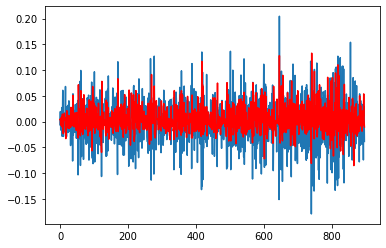

Train MSE: 0.001663


In [7]:

predictions = model.predict(new_train_X)
predictions_rescaled=scaler.inverse_transform(predictions.reshape(-1, 1))
Y = pd.DataFrame(train[window_size:])
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(train[window_size:],predictions_rescaled)
print('Train MSE: %.6f' % error)

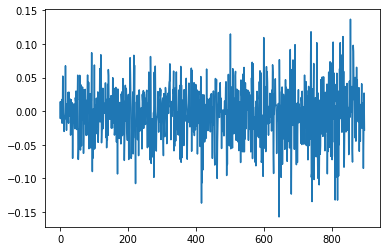

In [8]:
rawResiduals_SVR = Y - pred
plt.plot(rawResiduals_SVR)
plt.show()

rawResiduals_SVR.to_csv('rawResiduals_SVR_BO-TPE_standardscaler.csv', index=False)

In [9]:
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
import numpy as np


lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(rawResiduals_SVR, 5)
print(f"ARCH-LM p-value: {lm_pvalue}")


ARCH-LM p-value: 1.1884725342460769e-06


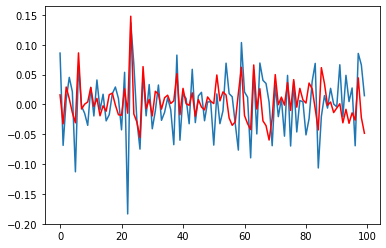

Test MSE: 0.001865


In [10]:
test_extended = train.tolist()[-1*window_size:] + test
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
test_scaled = scaler.transform(test_data)
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)
predictions = model.predict(new_test_X)
predictions_rescaled=scaler.inverse_transform(predictions.reshape(-1, 1))
predictions_rescaled = predictions_rescaled.flatten().tolist()

Y = pd.DataFrame(test)
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(test,predictions_rescaled)
print('Test MSE: %.6f' % error)

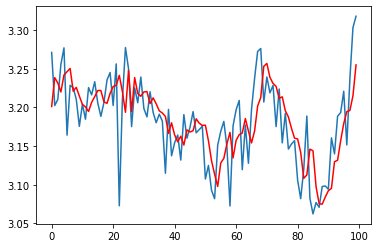

Test MSE: 0.001865


In [11]:
predicted_log_prices = np.zeros(len(logclose_test)) 
predicted_log_prices[0] = logclose_train[-1] + predictions_rescaled[0]

for t in range(1, len(logclose_test)):
    predicted_log_prices[t] = logclose_test[t-1] + predictions_rescaled[t] 


Y = pd.DataFrame(logclose_test)
pred = pd.DataFrame(predicted_log_prices)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()

error = mse(logclose_test,predicted_log_prices)
print('Test MSE: %.6f' % error)

In [12]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on logclose: ")
print(compute_error_metrics(logclose_test, predicted_log_prices))
print(compute_directional_metrics(logclose_test, predicted_log_prices))


Errors on logclose: 
{'NMSE': 0.6077539158247964, 'MAE': 0.033791298716188904, 'RMSE': 0.04319013907343676, 'MSE': 0.0018653881131828086, 'MAPE': 1.0641875213517105, 'TheilsU': 0.8537163367681326}
{'DA': 0.6565656565656566, 'DS': 0.43434343434343436, 'CU': 0.45454545454545453, 'CD': 0.4090909090909091}


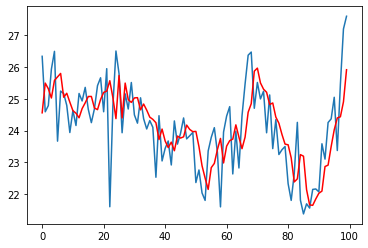

Test MSE: 1.077429


In [13]:
predicted_prices = np.exp(predicted_log_prices)
Y = pd.DataFrame(close_test)
pred = pd.DataFrame(predicted_prices)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()

error = mse(close_test,predicted_prices)
print('Test MSE: %.6f' % error)

In [14]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on close: ")
print(compute_error_metrics(close_test, predicted_prices))
print(compute_directional_metrics(close_test, predicted_prices))

Errors on close: 
{'NMSE': 0.6087551660656133, 'MAE': 0.813953933210514, 'RMSE': 1.0379929589459358, 'MSE': 1.077429382821339, 'MAPE': 3.3940119646152107, 'TheilsU': 0.8483122962486845}
{'DA': 0.6565656565656566, 'DS': 0.43434343434343436, 'CU': 0.45454545454545453, 'CD': 0.4090909090909091}


Stock: 26.339 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26339.0
Stock: 24.591 Action: Buy Portfolio: 26336.96 Stocks: 1071 Balance_init: 2 total($) 26338.96
Stock: 24.786 Action: Bought--Holding Portfolio: 26545.81 Stocks: 1071 Balance_init: 2 total($) 26547.81
Stock: 25.934 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27777.31
Stock: 26.495 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27777.31
Stock: 23.666 Action: Buy Portfolio: 27760.22 Stocks: 1173 Balance_init: 17 total($) 27777.22
Stock: 25.243 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29627.04
Stock: 25.166 Action: Buy Portfolio: 29620.38 Stocks: 1177 Balance_init: 6 total($) 29626.38
Stock: 24.793 Action: Bought--Holding Portfolio: 29181.36 Stocks: 1177 Balance_init: 6 total($) 29187.36
Stock: 23.938 Action: Bought--Holding Portfolio: 28175.03 Stocks: 1177 Balance_init: 6 total($) 28181.03
Stock: 24.631 Acti

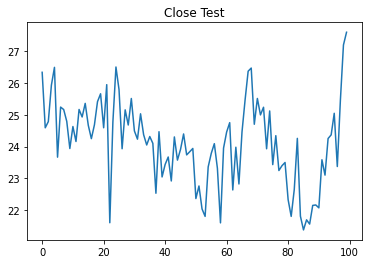

Final value of stock:
27601.0


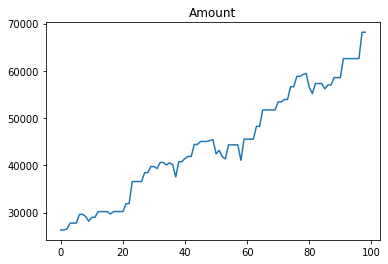

Final value of portfolio:
68151.0
TS=
2.4691496684902723


In [15]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from trading_strategies import trading_strategy1

trading_strategy1(close_test, predicted_prices)
            

In [16]:
68151.0/(1000*27.601)

2.4691496684902723